Implementing a neural network to solve a multi class classification problem and evaluate different weight initialization techniques

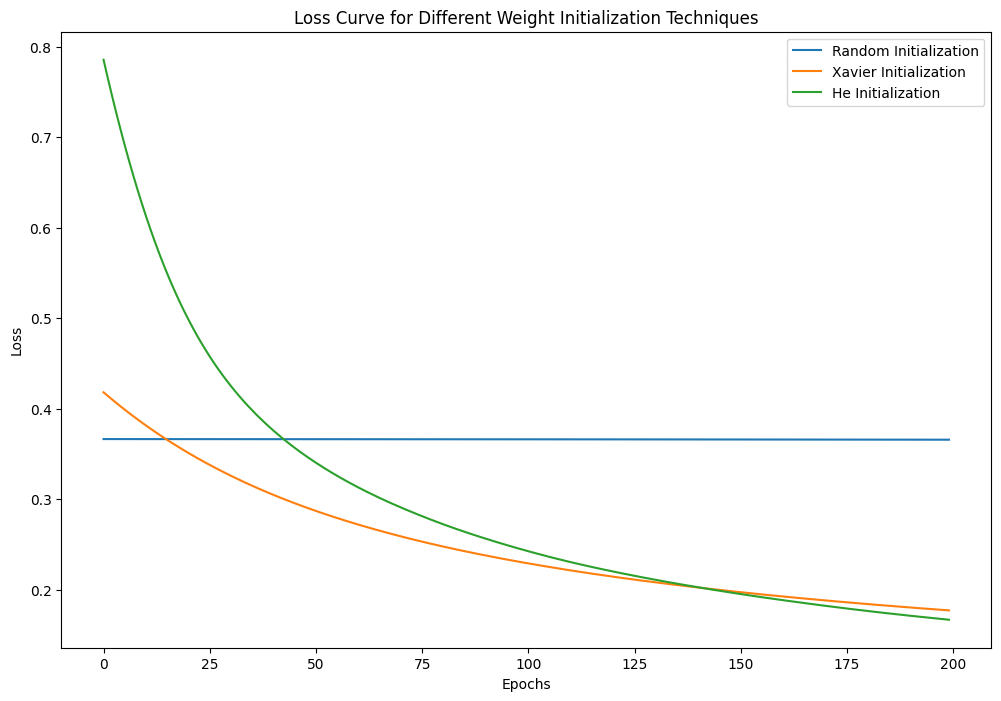

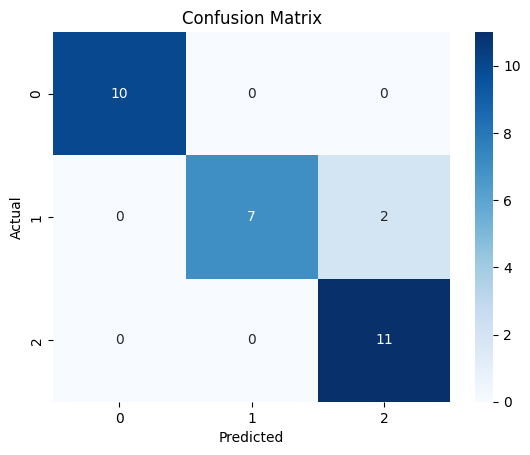

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# One-hot encoding for multi-class classification
ohe = OneHotEncoder(sparse_output=False)
y_encoded = ohe.fit_transform(y.reshape(-1, 1))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Activation Function
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

def relu_deriv(x):
    return (x > 0).astype(float)

# Weight Initialization Methods
def random_init(shape):
    return np.random.randn(*shape) * 0.01

def xavier_init(shape):
    return np.random.randn(*shape) * np.sqrt(1. / shape[0])

def he_init(shape):
    return np.random.randn(*shape) * np.sqrt(2. / shape[0])

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, init_method, lr=0.01):
        self.W1 = init_method((input_dim, hidden_dim))
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = init_method((hidden_dim, output_dim))
        self.b2 = np.zeros((1, output_dim))
        self.lr = lr

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = softmax(self.z2)
        return self.a2

    def backward(self, X, y):
        m = y.shape[0]
        dz2 = self.a2 - y
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = (dz2 @ self.W2.T) * relu_deriv(self.z1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def train(self, X, y, epochs=100):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = -np.mean(y * np.log(y_pred + 1e-8))  # Cross-entropy loss
            losses.append(loss)
            self.backward(X, y)
        return losses

# Testing with different weight initialization techniques
init_methods = {'Random': random_init, 'Xavier': xavier_init, 'He': he_init}

plt.figure(figsize=(12, 8))
for name, init in init_methods.items():
    nn = NeuralNetwork(4, 10, 3, init, lr=0.01)
    losses = nn.train(X_train, y_train, epochs=200)
    plt.plot(losses, label=f'{name} Initialization')

plt.title('Loss Curve for Different Weight Initialization Techniques')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix for the best performing model
best_nn = NeuralNetwork(4, 10, 3, he_init)
best_nn.train(X_train, y_train, epochs=200)
y_pred = np.argmax(best_nn.forward(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



